In [ ]:
import cv2 as cv
import pandas as pd
import numpy as np
import glob
import sys
import random
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/DM/'

In [ ]:
#config dictionary
config_dictionary ={"Image_set":ROOT+"Images/",
                      "common_landing_location":ROOT+"Common/",
                      "bread_info":["n02085936-Maltese_dog","n02096294-Australian_terrier","n02106550-Rottweiler","n02092339-Weimaraner"]
                    }

In [ ]:
files_dict={}
for bread in config_dictionary['bread_info']:
  files_dict[bread]=glob.glob(config_dictionary['Image_set']+bread+"/*.jpg")
  if '.DS_Store' in files_dict[bread]:
    files_dict[bread].remove('.DS_Store')

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# image modification
modify_dict ={}
df_image = pd.DataFrame()
count=0
for bread in list(files_dict.keys()):
    print("Processing the bread -- > "+str(bread))
    temp_image = pd.DataFrame()
    for file in files_dict[bread]:
        annotation_path = file.replace("Images","Annotation")
        annotation_path=annotation_path.split(".")[0]
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = root.findall('object')
        bbox = []
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bbox.append((xmin,ymin,xmax,ymax))
        image = Image.open(file)
        for value in range(len(bbox)):
            cropped_image = image.crop(bbox[value])
            modified_image = cropped_image.resize((224,224),Image.LANCZOS)
            modified_image = modified_image.convert('RGB')
            temp = "/".join(file.split("/")[:-1])
            temp+="/cropped_images/"
            Path(temp).mkdir(parents=True, exist_ok=True)
            modified_image.save(temp+file.split("/")[-1])
            modified_image.save(config_dictionary["common_landing_location"]+file.split("/")[-1])
        temp_image = temp_image.append({'image_file_path': config_dictionary["common_landing_location"]+file.split("/")[-1],"file_name":file.split("/")[-1]}, ignore_index=True)
    temp_image["label"]=count
    count+=1
    df_image = df_image.append(temp_image,ignore_index=True)

Processing the bread -- > n02085936-Maltese_dog
Processing the bread -- > n02096294-Australian_terrier
Processing the bread -- > n02106550-Rottweiler
Processing the bread -- > n02092339-Weimaraner


In [ ]:
final_df = pd.DataFrame()

In [ ]:
for index,row in df_image.iterrows():
  load_image = cv.imread(row['image_file_path'])
  gray_converted_image = cv.cvtColor(load_image, cv.COLOR_BGR2GRAY)
  histogram_image_values = cv.calcHist([gray_converted_image],[0],None,[256],[0,256])
  temp = pd.DataFrame(histogram_image_values).T
  temp['file_name']=row['file_name']
  temp["label"]=row["label"]
  final_df =pd.concat([final_df,temp],ignore_index=True)

In [ ]:
std_df = final_df.loc[:,:255]
scaler_obj = StandardScaler()
std_df = pd.DataFrame(scaler_obj.fit_transform(std_df),columns=std_df.columns)
pca = PCA(n_components=2)
PCA_analysis = pca.fit_transform(std_df)

In [ ]:
PCA_analysis

array([[  0.96293306,  -3.628442  ],
       [  6.008365  ,   1.2796108 ],
       [ -8.074931  ,   2.410347  ],
       ...,
       [  6.0723286 ,  -6.4275737 ],
       [  6.088148  ,  -4.0233555 ],
       [  5.0139413 , -14.941984  ]], dtype=float32)

In [ ]:
from sklearn.cluster import KMeans,SpectralClustering,BisectingKMeans
from sklearn.metrics import fowlkes_mallows_score, silhouette_samples, silhouette_score

In [ ]:
try:
  km_random = KMeans(n_clusters=4, init='random')
  kmeans_plusplus = KMeans(n_clusters=4, init='k-means++')
  bisecting_km = BisectingKMeans(n_clusters=4, init='random')
  spectral_clustering_km = SpectralClustering(n_clusters=4)
except Exception as error:
  print(error)
  sys.exit(1)

In [ ]:
km_random_fitting = km_random.fit(PCA_analysis)
km_random_fms = fowlkes_mallows_score(final_df['label'],km_random_fitting.labels_)
km_random_ss = silhouette_score(PCA_analysis,km_random_fitting.labels_)
print(f" for K-means with init random ,fowlkes mallows score was {km_random_fms} and silhouette score {km_random_ss}")

 for K-means with init random ,fowlkes mallows score was 0.3339415154566999 and silhouette score 0.335628479719162


In [ ]:
kmeans_plusplus_fitting = kmeans_plusplus.fit(PCA_analysis)
kmeans_plusplus_fms = fowlkes_mallows_score(final_df['label'],kmeans_plusplus_fitting.labels_)
kmeans_plusplus_ss = silhouette_score(PCA_analysis,kmeans_plusplus_fitting.labels_)
print(f" for K-means with init K-means++ ,fowlkes mallows score was {kmeans_plusplus_fms} and silhouette score {kmeans_plusplus_ss}")

 for K-means with init K-means++ ,fowlkes mallows score was 0.331465840052503 and silhouette score 0.3352200984954834


In [ ]:
bisecting_km_fitting = bisecting_km.fit(PCA_analysis)
bisecting_km_fms = fowlkes_mallows_score(final_df['label'],bisecting_km_fitting.labels_)
bisecting_km_ss = silhouette_score(PCA_analysis,bisecting_km_fitting.labels_)
print(f" For Bisecting K-means,fowlkes mallows score was {bisecting_km_fms} and silhouette score {bisecting_km_ss}")

 For Bisecting K-means,fowlkes mallows score was 0.33213459102498955 and silhouette score 0.3274904787540436


In [ ]:
spectral_clustering_km_fitting = spectral_clustering_km.fit(PCA_analysis)
spectral_clustering_km_fms = fowlkes_mallows_score(final_df['label'],spectral_clustering_km_fitting.labels_)
spectral_clustering_km_ss = silhouette_score(PCA_analysis,spectral_clustering_km_fitting.labels_)
print(f" For spectral clustering K-means,fowlkes mallows score was {spectral_clustering_km_fms} and silhouette score {spectral_clustering_km_ss}")

 For spectral clustering K-means,fowlkes mallows score was 0.4993157581856823 and silhouette score 0.11093030869960785


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs

In [ ]:
feature,true_label = make_blobs(n_samples=final_df.shape[0],centers=PCA_analysis,cluster_std=0.4,random_state=3)
feature = scaler_obj.fit_transform(feature)

In [ ]:
eps_value = 0.245
min_sample_value = 4

In [ ]:
dbscan_result = DBSCAN(eps=eps_value,min_samples=min_sample_value).fit(feature)
labels = dbscan_result.labels_
print(f"we get {len(set(dbscan_result.labels_)) - (1 if -1 in dbscan_result.labels_ else 0)} cluster for eps value {eps_value} with min sample value {min_sample_value}")

we get 4 cluster for eps value 0.245 with min sample value 4


In [ ]:
dbscan_fms = fowlkes_mallows_score(final_df['label'],labels)
dbscan_ss = silhouette_score(PCA_analysis,labels)
print(f" For DBSCAN,fowlkes mallows score was {dbscan_fms} and silhouette score {dbscan_ss}")

 For DBSCAN,fowlkes mallows score was 0.4628535820198839 and silhouette score -0.2107430249452591


In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
try:
  single_cluster= AgglomerativeClustering(n_clusters=4, linkage='single')
  complete_cluster = AgglomerativeClustering(n_clusters=4, linkage='complete')
  average_cluster = AgglomerativeClustering(n_clusters=4, linkage='average')
  ward_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
except Exception as error:
  print(error)
  sys.exit(1)

Text(0.5, 1.0, 'Plot for: single linkage Agglomerative clustering with 4 clusters')

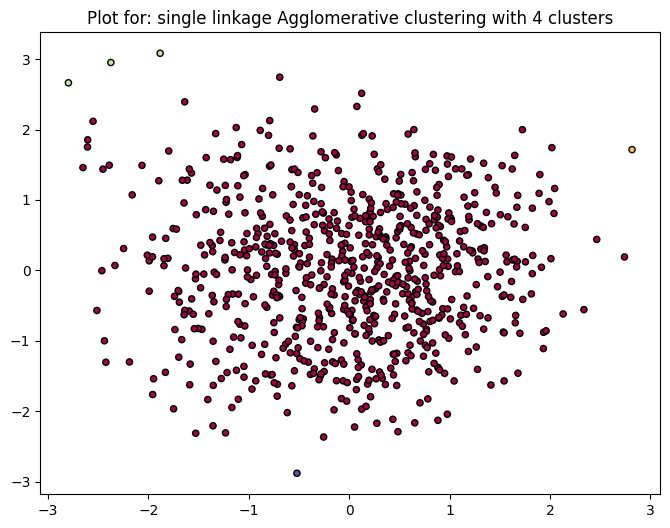

In [ ]:
single_cluster_result = single_cluster.fit(feature)
cluster_labels = single_cluster_result.labels_
n_clusters_ = len(set(cluster_labels))
unique_labels = set(single_cluster_result.labels_)
core_samples_mask = np.zeros_like(single_cluster_result.labels_, dtype=bool)
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(feature[:, 0], feature[:, 1], c=cluster_labels, cmap='Spectral',
                        s=20, edgecolors='black', linewidths=1)

plt.title(f"Plot for: single linkage Agglomerative clustering with {n_clusters_} clusters")


In [ ]:
single_cluster_fms = fowlkes_mallows_score(final_df['label'],cluster_labels)
single_cluster_ss = silhouette_score(feature,cluster_labels)
print(f" For single linkage Agglomerative clustering,fowlkes mallows score was {single_cluster_fms} and silhouette score {single_cluster_ss}")

 For single linkage Agglomerative clustering,fowlkes mallows score was 0.5069336410847054 and silhouette score 0.21308230606623124


Text(0.5, 1.0, 'Plot for: Complete linkage Agglomerative clustering with 4 clusters')

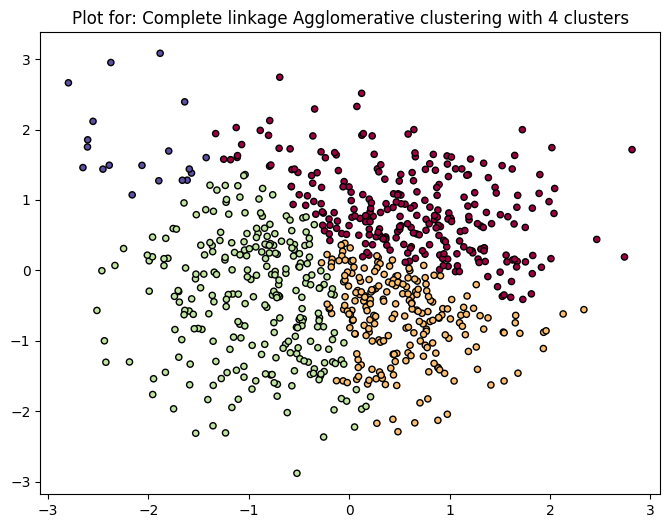

In [ ]:
complete_cluster_result = complete_cluster.fit(feature)
cluster_labels = complete_cluster_result.labels_
n_clusters_ = len(set(cluster_labels))
unique_labels = set(complete_cluster_result.labels_)
core_samples_mask = np.zeros_like(complete_cluster_result.labels_, dtype=bool)
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(feature[:, 0], feature[:, 1], c=cluster_labels, cmap='Spectral',
                        s=20, edgecolors='black', linewidths=1)

plt.title(f"Plot for: Complete linkage Agglomerative clustering with {n_clusters_} clusters")


Text(0.5, 1.0, 'Plot for: Complete linkage Agglomerative clustering with 4 clusters')

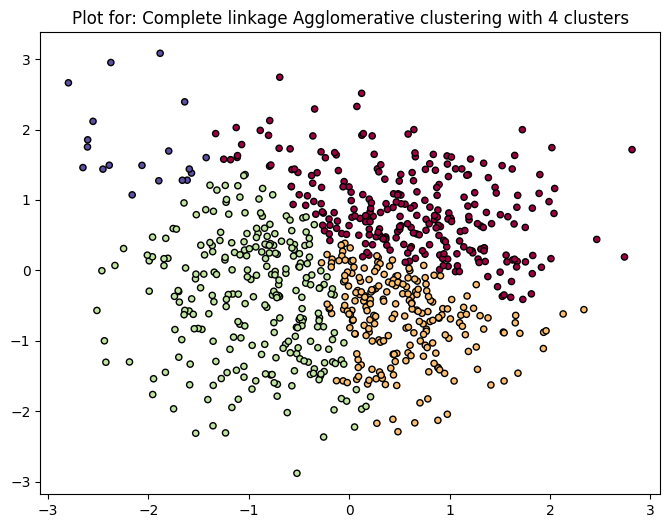

In [ ]:
complete_cluster_result = complete_cluster.fit(feature)
cluster_labels = complete_cluster_result.labels_
n_clusters_ = len(set(cluster_labels))
unique_labels = set(complete_cluster_result.labels_)
core_samples_mask = np.zeros_like(complete_cluster_result.labels_, dtype=bool)
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(feature[:, 0], feature[:, 1], c=cluster_labels, cmap='Spectral',
                        s=20, edgecolors='black', linewidths=1)

plt.title(f"Plot for: Complete linkage Agglomerative clustering with {n_clusters_} clusters")


In [ ]:
complete_cluster_fms = fowlkes_mallows_score(final_df['label'],cluster_labels)
complete_cluster_ss = silhouette_score(feature,cluster_labels)
print(f" For Complete linkage Agglomerative clustering,fowlkes mallows score was {complete_cluster_fms} and silhouette score {complete_cluster_ss}")

 For Complete linkage Agglomerative clustering,fowlkes mallows score was 0.2902225276588429 and silhouette score 0.2760243734990069


Text(0.5, 1.0, 'Plot for: Average linkage Agglomerative clustering with 4 clusters')

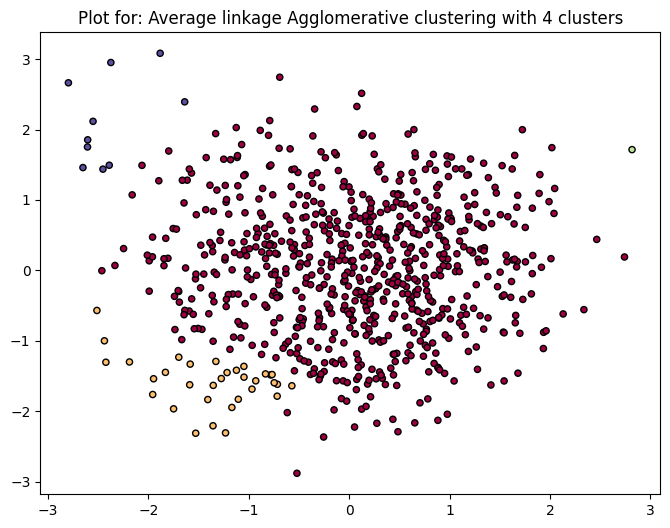

In [ ]:
average_cluster_result = average_cluster.fit(feature)
cluster_labels = average_cluster_result.labels_
n_clusters_ = len(set(cluster_labels))
unique_labels = set(average_cluster_result.labels_)
core_samples_mask = np.zeros_like(average_cluster_result.labels_, dtype=bool)
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(feature[:, 0], feature[:, 1], c=cluster_labels, cmap='Spectral',
                        s=20, edgecolors='black', linewidths=1)

plt.title(f"Plot for: Average linkage Agglomerative clustering with {n_clusters_} clusters")


In [ ]:
average_cluster_fms = fowlkes_mallows_score(final_df['label'],cluster_labels)
average_cluster_ss = silhouette_score(feature,cluster_labels)
print(f" For Average linkage Agglomerative clustering,fowlkes mallows score was {average_cluster_fms} and silhouette score {average_cluster_ss}")

 For Average linkage Agglomerative clustering,fowlkes mallows score was 0.4838149757860506 and silhouette score 0.16883021037231244


Text(0.5, 1.0, 'Plot for: Ward linkage Agglomerative clustering with 4 clusters')

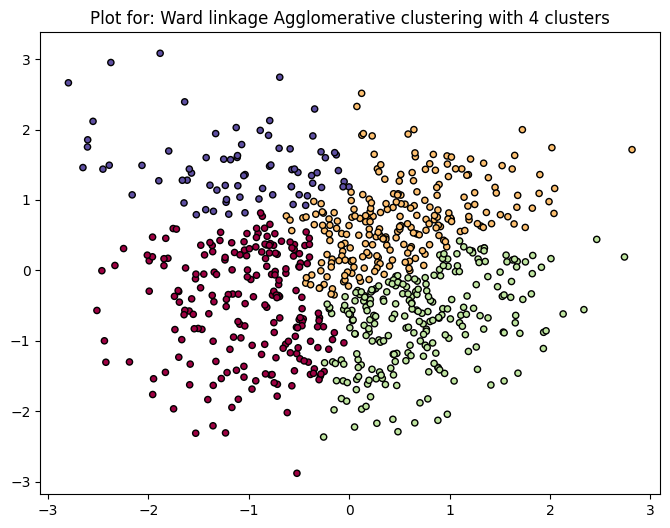

In [ ]:
ward_cluster_result = ward_cluster.fit(feature)
cluster_labels = ward_cluster_result.labels_
n_clusters_ = len(set(cluster_labels))
unique_labels = set(ward_cluster_result.labels_)
core_samples_mask = np.zeros_like(ward_cluster_result.labels_, dtype=bool)
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(feature[:, 0], feature[:, 1], c=cluster_labels, cmap='Spectral',
                        s=20, edgecolors='black', linewidths=1)

plt.title(f"Plot for: Ward linkage Agglomerative clustering with {n_clusters_} clusters")


In [ ]:
ward_cluster_fms = fowlkes_mallows_score(final_df['label'],cluster_labels)
ward_cluster_ss = silhouette_score(feature,cluster_labels)
print(f" For Average linkage Agglomerative clustering,fowlkes mallows score was {ward_cluster_fms} and silhouette score {ward_cluster_ss}")

 For Average linkage Agglomerative clustering,fowlkes mallows score was 0.2701399679466143 and silhouette score 0.30417996781496065


In [ ]:
fms_Score = [("Agglomerative_ward_linkage",ward_cluster_fms),
("Agglomerative_average_linkage",average_cluster_fms),
("Agglomerative_complete_linkage",complete_cluster_fms),
("Agglomerative_single_linkage",single_cluster_fms),
("DBSCAN",dbscan_fms),
("Spectral Clustering",spectral_clustering_km_fms),
("Bisecting Clustering",bisecting_km_fms),
("K-means ++",kmeans_plusplus_fms),
("K-means random",km_random_fms)]

In [ ]:
sorted_vars = sorted(fms_Score, key=lambda x: x[1], reverse=True)

In [ ]:
for name, value in sorted_vars:
    print(f"{name}: {value}")

Agglomerative_single_linkage: 0.5069336410847054
Spectral Clustering: 0.4993157581856823
Agglomerative_average_linkage: 0.4838149757860506
DBSCAN: 0.4628535820198839
K-means random: 0.3339415154566999
Bisecting Clustering: 0.33213459102498955
K-means ++: 0.331465840052503
Agglomerative_complete_linkage: 0.2902225276588429
Agglomerative_ward_linkage: 0.2701399679466143


In [ ]:
ss_Score = [("Agglomerative_ward_linkage",ward_cluster_ss),
("Agglomerative_average_linkage",average_cluster_ss),
("Agglomerative_complete_linkage",complete_cluster_ss),
("Agglomerative_single_linkage",single_cluster_ss),
("DBSCAN",dbscan_ss),
("Spectral Clustering",spectral_clustering_km_ss),
("Bisecting Clustering",bisecting_km_ss),
("K-means ++",kmeans_plusplus_ss),
("K-means random",km_random_ss)]

In [ ]:
sorted_vars = sorted(ss_Score, key=lambda x: x[1], reverse=True)

In [ ]:
for name, value in sorted_vars:
    print(f"{name}: {value}")

K-means random: 0.335628479719162
K-means ++: 0.3352200984954834
Bisecting Clustering: 0.3274904787540436
Agglomerative_ward_linkage: 0.30417996781496065
Agglomerative_complete_linkage: 0.2760243734990069
Agglomerative_single_linkage: 0.21308230606623124
Agglomerative_average_linkage: 0.16883021037231244
Spectral Clustering: 0.11093030869960785
DBSCAN: -0.2107430249452591


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os
device = torch.device('cpu')
FEATURES_carrier = []
t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class ImageData(Dataset):
    def __init__(self, data, directory, transform):
        self.data = data
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path_info = os.path.join(self.directory, self.data.iloc[idx]['file_name'])
        try:
          if os.path.exists(path_info):
              image = Image.open(path_info)
              image = self.transform(image)
              return image
        except Exception as error:
            print("Exception occur due to {0}".format(str(error)))
            return None

In [ ]:
def get_features(module, input, output):
    FEATURES_carrier.append(output.detach())

In [ ]:
data_set_loader = ImageData(data= df_image,
                         directory="/content/drive/MyDrive/DM/Common", # need to mention the merge data path
                         transform=t)

In [ ]:
data_loader = DataLoader(data_set_loader,batch_size=20)

In [ ]:
model = models.resnet18(pretrained=True)
layer = model.layer4[-1]
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
forward_hook = layer.register_forward_hook(get_features)

In [ ]:
for idx, inputs in enumerate(data_loader):
    model(inputs)
forward_hook.remove()
FEATURES_carrier = torch.cat(FEATURES_carrier).numpy()
print('extracted image features:', FEATURES_carrier.shape)

extracted image features: (760, 512, 7, 7)


**Reference**

1. https://kozodoi.me/blog/20210527/extracting-features
2. https://www.kaggle.com/code/espriella/stanford-dogs-transfer-crop-stack/notebook